In [ ]:
# Ch11-4-population-structure

In [1]:
# 22. Load PLINK data with sgkit
from collections import defaultdict 
from pprint import pprint 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import xarray as xr 
import sgkit as sg 
from sgkit.io import plink 
data = plink.read_plink(path='hapmap10_auto_noofs_ld', fam_sep='\t') 

In [2]:
# 23.  Load data assigning individuals to populations
f = open('data/relationships_w_pops_041510.txt') 
pop_ind = defaultdict(list) 
f.readline()
for line in f: 
    toks = line.rstrip().split('\t') 
    fam_id = toks[0] 
    ind_id = toks[1] 
    pop = toks[-1] 
    pop_ind[pop].append((fam_id, ind_id)) 
pops = list(pop_ind.keys()) 

In [3]:
# 24.  Inform sgkit about populations and samples
def assign_cohort(pops, pop_ind, sample_family_id, sample_id): 
    cohort = [] 
    for fid, sid in zip(sample_family_id, sample_id): 
        processed = False 
        for i, pop in enumerate(pops): 
            if (fid, sid) in pop_ind[pop]: 
                processed = True 
                cohort.append(i) 
                break 
        if not processed: 
            raise Exception(f'Not processed {fid}, {sid}') 
    return cohort 
cohort = assign_cohort(pops, pop_ind, data.sample_family_id.values, data.sample_id.values) 
data['sample_cohort'] = xr.DataArray(cohort, dims='samples') 

In [4]:
# 25.  Compute statistics
cohort_allele_frequency = sg.cohort_allele_frequencies(data)['cohort_allele_frequency'].values 
monom = {} 
for i, pop in enumerate(pops): 
    monom[pop] = len(list(filter(lambda x: x, np.isin(cohort_allele_frequency[:, i, 0], [0, 1])))) 
pprint(monom) 

{'ASW': 3318,
 'CEU': 8977,
 'CHB': 11123,
 'CHD': 12294,
 'GIH': 9050,
 'JPT': 12921,
 'LWK': 3892,
 'MEX': 6530,
 'MKK': 3456,
 'TSI': 8707,
 'YRI': 5123}


In [6]:
# 26. Get minimum allele frequency
mafs = {} 
for i, pop in enumerate(pops): 
    min_freqs = map( 
        lambda x: x if x < 0.5 else 1 - x, 
        filter( 
            lambda x: x not in [0, 1], cohort_allele_frequency[:, i, 0])) 
    mafs[pop] = pd.Series(min_freqs) 

Text(0.5, 0, 'MAF')

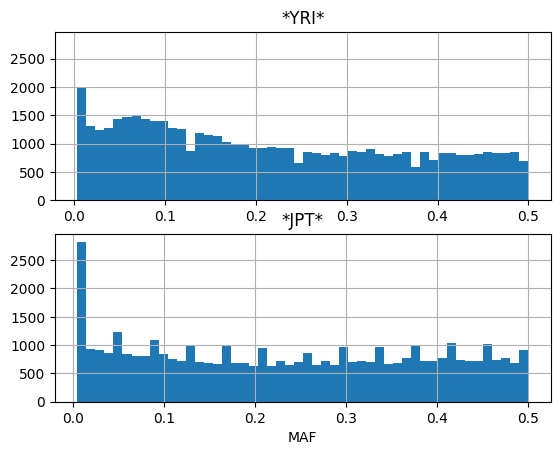

In [7]:
# 27. Print MAF histograms
maf_plot, maf_ax = plt.subplots(nrows=2, sharey=True) 
mafs['YRI'].hist(ax=maf_ax[0], bins=50) 
maf_ax[0].set_title('*YRI*') 
mafs['JPT'].hist(ax=maf_ax[1], bins=50) 
maf_ax[1].set_title('*JPT*') 
maf_ax[1].set_xlabel('MAF') 

In [9]:
# 28.  Compute FST
fst = sg.Fst(data) 
fst = fst.assign_coords({"cohorts_0": pops, "cohorts_1": pops}) 

In [11]:
# 29.  Compare FST between populations
remove_nan = lambda data: filter(lambda x: not np.isnan(x), data) 
ceu_chb = pd.Series(remove_nan(fst.stat_Fst.sel(cohorts_0='CEU', cohorts_1='CHB').values)) 
chb_chd = pd.Series(remove_nan(fst.stat_Fst.sel(cohorts_0='CHB', cohorts_1='CHD').values)) 
ceu_chb.describe() 
chb_chd.describe() 

count    44993.000000
mean         0.000463
std          0.006123
min         -0.004313
25%         -0.003616
50%         -0.001655
75%          0.001898
max          0.064035
dtype: float64

In [12]:
# 30.  Plot distance matrix
mean_fst = {} 
for i, pop_i in enumerate(pops): 
    for j, pop_j in enumerate(pops): 
        if j <= i: 
            continue 
        pair_fst = pd.Series(remove_nan(fst.stat_Fst.sel(cohorts_0=pop_i, cohorts_1=pop_j).values)) 
        mean = pair_fst.mean() 
        mean_fst[(pop_i, pop_j)] = mean 
min_pair = min(mean_fst.values()) 
max_pair = max(mean_fst.values()) 

[Text(0, 0, 'ASW'),
 Text(0, 1, 'CEU'),
 Text(0, 2, 'CHB'),
 Text(0, 3, 'CHD'),
 Text(0, 4, 'GIH'),
 Text(0, 5, 'JPT'),
 Text(0, 6, 'LWK'),
 Text(0, 7, 'MEX'),
 Text(0, 8, 'MKK'),
 Text(0, 9, 'TSI')]

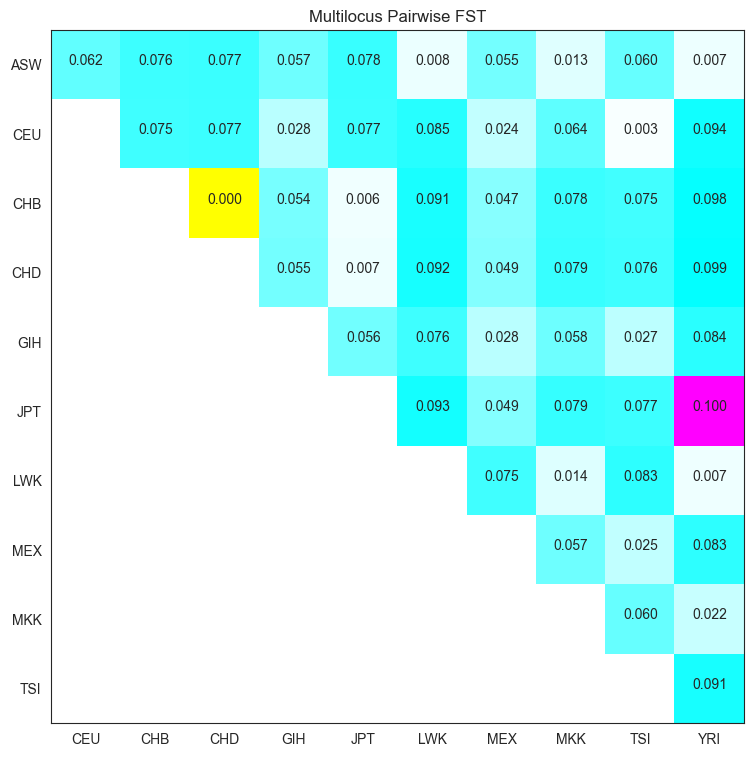

In [13]:
# 31.  Pairwise plot
sns.set_style("white") 
num_pops = len(pops) 
arr = np.ones((num_pops - 1, num_pops - 1, 3), dtype=float) 
fig = plt.figure(figsize=(16, 9)) 
ax = fig.add_subplot(111) 
for row in range(num_pops - 1): 
    pop_i = pops[row] 
    for col in range(row + 1, num_pops): 
        pop_j = pops[col] 
        val = mean_fst[(pop_i, pop_j)] 
        norm_val = (val - min_pair) / (max_pair - min_pair) 
        ax.text(col - 1, row, '%.3f' % val, ha='center') 
        if norm_val == 0.0: 
            arr[row, col - 1, 0] = 1 
            arr[row, col - 1, 1] = 1 
            arr[row, col - 1, 2] = 0 
        elif norm_val == 1.0: 
            arr[row, col - 1, 0] = 1 
            arr[row, col - 1, 1] = 0 
            arr[row, col - 1, 2] = 1 
        else: 
            arr[row, col - 1, 0] = 1 - norm_val 
            arr[row, col - 1, 1] = 1 
            arr[row, col - 1, 2] = 1 
ax.imshow(arr, interpolation='none') 
ax.set_title('Multilocus Pairwise FST') 
ax.set_xticks(range(num_pops - 1)) 
ax.set_xticklabels(pops[1:]) 
ax.set_yticks(range(num_pops - 1)) 
ax.set_yticklabels(pops[:-1]) 

In [ ]:
## End of Notebook ##